In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize(28),        # Resize images to 28x28 for consistency
    transforms.Grayscale(num_output_channels=1),  # Ensure 1 channel (grayscale)
    transforms.ToTensor(),        # Convert to tensor (values in [0,1])
])

# Load FashionMNIST dataset
train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

# Define DataLoader for training
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, pin_memory=True)

# Print dataset size
print(f"Training set size: {len(train_dataset)}, Test set size: {len(test_dataset)}")

# Define FashionMNIST class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(class_names)


Training set size: 60000, Test set size: 10000
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.img_size = 28 * 28  # FashionMNIST images are 28x28

        # Encoder: Fully connected layers
        self.encoder = nn.Sequential(
            nn.Flatten(),  # Flatten image to 784
            nn.Linear(self.img_size, 512),
            nn.ReLU(),
            nn.Linear(512, 2 * latent_dim)  # Outputs mu and logvar concatenated
        )

        # Decoder: Fully connected layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, self.img_size),
            nn.Sigmoid()  # Sigmoid to output values in [0,1] for BCE loss
        )

    def encode(self, x):
        """Encodes input images into latent mean and log-variance vectors."""
        h = self.encoder(x)  # (batch, 2*latent_dim)
        mu = h[:, :self.latent_dim]
        logvar = h[:, self.latent_dim:]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Samples z from N(mu, sigma^2) using the reparameterization trick."""
        std = torch.exp(0.5 * logvar)  # Compute standard deviation
        eps = torch.randn_like(std)  # Sample epsilon ~ N(0, I)
        z = mu + eps * std  # Reparameterization trick
        return z

    def decode(self, z):
        """Decodes latent vector z to reconstructed image."""
        x_reconst_flat = self.decoder(z)  # Output is flattened image
        x_reconst = x_reconst_flat.view(-1, 1, 28, 28)  # Reshape to (batch, 1, 28, 28)
        return x_reconst

    def forward(self, x):
        #TODO
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconst = self.decode(z)
        return x_reconst, mu, logvar

# Instantiate the VAE model
latent_dim = 20  # Adjustable latent dimension
vae = VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

print(f"VAE model initialized with latent dimension: {latent_dim}")

Using device: cuda
VAE model initialized with latent dimension: 20


In [5]:
def loss_function(recon_x, x, mu, logvar):
    """Computes the VAE loss: Reconstruction loss + KL divergence"""
    # Reconstruction loss (BCE)
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum') / x.size(0)
    
    # KL divergence loss (per batch average)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    
    return recon_loss + kl_loss

In [6]:
# Load FashionMNIST dataset
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# Training loop
num_epochs = 20
vae.train()
for epoch in range(1, num_epochs + 1):
    total_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)

        optimizer.zero_grad()
        recon_images, mu, logvar = vae(images)
        loss = loss_function(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/20], Loss: 273.3886
Epoch [2/20], Loss: 251.2754
Epoch [3/20], Loss: 246.9805
Epoch [4/20], Loss: 245.0348
Epoch [5/20], Loss: 243.9351
Epoch [6/20], Loss: 243.0979
Epoch [7/20], Loss: 242.5297
Epoch [8/20], Loss: 241.9791
Epoch [9/20], Loss: 241.6288
Epoch [10/20], Loss: 241.2674
Epoch [11/20], Loss: 241.0453
Epoch [12/20], Loss: 240.7547
Epoch [13/20], Loss: 240.5179
Epoch [14/20], Loss: 240.3780
Epoch [15/20], Loss: 240.2027
Epoch [16/20], Loss: 240.0149
Epoch [17/20], Loss: 239.8817
Epoch [18/20], Loss: 239.7424
Epoch [19/20], Loss: 239.6085
Epoch [20/20], Loss: 239.5161


In [67]:
def metropolis_hastings_completion(vae, left_half, num_samples=1000, burn_in=100, step_size=0.1):
    """
    Implements Metropolis-Hastings to sample the right half of an image given the left half.
    
    Args:
        vae: Trained VAE model
        left_half: Tensor of shape [1, 1, 28, 14] containing the left half of the image
        num_samples: Total number of samples to generate
        burn_in: Number of initial samples to discard
        step_size: Size of the random steps in latent space
        
    Returns:
        samples: List of accepted samples after burn-in
        acceptance_rate: Fraction of proposals that were accepted
        posterior_probs: List of posterior probabilities (likelihood + prior) for monitoring convergence
    """
    device = next(vae.parameters()).device
    vae.eval()  # Set VAE to evaluation mode
    
    # Create a template for the full image with zeros on the right half
    img_template = torch.zeros(1, 1, 28, 28, device=device)
    img_template[:, :, :, :14] = left_half
    
    # Initialize with a random latent vector
    current_z = torch.randn(1, vae.latent_dim, device=device)
    
    # Decode to get initial image
    current_x = vae.decode(current_z)
    
    # Ensure the left half matches the observed left half
    current_x_with_left = current_x.clone()
    current_x_with_left[:, :, :, :14] = left_half
    
    # Calculate initial likelihood (BCE on left half only)
    current_likelihood = -F.binary_cross_entropy(
        current_x[:, :, :, :14], 
        left_half, 
        reduction='sum'
    )
    
    # Calculate initial prior probability (log probability under N(0,I))
    current_prior = -0.5 * torch.sum(current_z ** 2)
    
    # Current posterior (log scale)
    current_posterior = current_likelihood + current_prior
    
    # Track samples, acceptance, and posterior probabilities
    samples = []
    posterior_probs = []
    accepted = 0
    
    # Store initial posterior
    posterior_probs.append(current_posterior.item())
    
    # Run Metropolis-Hastings
    for i in range(num_samples + burn_in):
        # Propose new latent vector with Gaussian step
        proposed_z = current_z + step_size * torch.randn_like(current_z)
        
        # Decode to get proposed image
        proposed_x = vae.decode(proposed_z)
        
        # Calculate proposed likelihood (BCE on left half only)
        proposed_likelihood = -F.binary_cross_entropy(
            proposed_x[:, :, :, :14], 
            left_half, 
            reduction='sum'
        )
        
        # Calculate proposed prior probability
        proposed_prior = -0.5 * torch.sum(proposed_z ** 2)
        
        # Calculate proposed posterior
        proposed_posterior = proposed_likelihood + proposed_prior
        
        # Calculate acceptance probability (in log space, then exponentiate)
        log_accept_ratio = proposed_posterior - current_posterior
        accept_prob = torch.min(torch.tensor(0.0, device=device), log_accept_ratio).exp().item()
        
        # Accept or reject
        if np.random.rand() < accept_prob:
            current_z = proposed_z
            current_x = proposed_x
            current_likelihood = proposed_likelihood
            current_prior = proposed_prior
            current_posterior = proposed_posterior
            accepted += 1
            
        # Save sample (after burn-in)
        if i >= burn_in:
            # Create completed image (left half is observed, right half is generated)
            completed_img = current_x.clone()
            completed_img[:, :, :, :14] = left_half
            samples.append(completed_img.detach().cpu())
        
        # Always store the posterior probability (including during burn-in)
        posterior_probs.append(current_posterior.item())
    
    acceptance_rate = accepted / (num_samples + burn_in)
    return samples, acceptance_rate, posterior_probs

In [77]:
def metropolis_hastings_completion_with_encoder(vae, left_half, num_samples=1000, burn_in=100, proposal_scale=1.0):
    """
    Implements Metropolis-Hastings to sample the right half of an image given the left half,
    using the VAE encoder for proposals with adjustable variance.
    
    Args:
        vae: Trained VAE model with encode and decode methods
        left_half: Tensor of shape [1, 1, 28, 14] containing the left half of the image
        num_samples: Total number of samples to generate
        burn_in: Number of initial samples to discard
        proposal_scale: Scaling factor for the proposal variance (higher values = more exploration)
        
    Returns:
        samples: List of accepted samples after burn-in
        acceptance_rate: Fraction of proposals that were accepted
    """
    device = next(vae.parameters()).device
    vae.eval()  # Set VAE to evaluation mode
    
    # Create a template for the full image with random initialization on the right half
    img_template = torch.rand(1, 1, 28, 28, device=device)
    img_template[:, :, :, :14] = left_half
    
    # Initial state
    current_x_right = img_template[:, :, :, 14:].clone()
    current_x_full = img_template.clone()
    
    # initialize z^(0)
    # TODO
    
    # initialize x_right^(0)
    # TODO
    
    # Track samples and acceptance
    samples = []
    posterior_probs = []
    accepted = 0
    
    # Run Metropolis-Hastings
    for i in range(num_samples + burn_in):
        # get the gaussian parameters for z from q(z | x)
        # TODO
        
        # optional: scale the variance to control the proposal width
        adjusted_logvar = proposed_logvar + 2 * torch.log(torch.tensor(proposal_scale, device=device))
        
        # sample z 
        proposed_z = vae.reparameterize(proposed_mu, adjusted_logvar)
        
        # x_right ~ p(x_right | z)
        proposed_x_right = vae.decode(proposed_z)[:, :, :, 14:]
        
        # Create full proposed image
        proposed_x_full = current_x_full.clone()
        proposed_x_full[:, :, :, 14:] = proposed_x_right
        
        # Calculate forward proposal probability: q(z_proposed | x_left, x_right_current)
        forward_mu, forward_logvar = vae.encode(current_x_full)
        forward_proposal_prob = log_normal_pdf(proposed_z, forward_mu, forward_logvar)
        
        # Calculate reverse proposal probability: q(z_current | x_left, x_right_proposed)
        # TODO
        
        # Calculate likelihood of proposed right half given the latent: p(x_right_proposed | z_proposed)
        proposed_likelihood = log_bernoulli_pdf(proposed_x_right, vae.decode(proposed_z)[:, :, :, 14:])
        
        # Calculate likelihood of current right half given the latent: p(x_right_current | z_current)
        current_likelihood = log_bernoulli_pdf(current_x_right_decoded, vae.decode(current_z)[:, :, :, 14:])
        
        # Calculate prior probabilities: p(z)
        # TODO
        
        # Calculate acceptance ratio (in log space)
        # g(x_right_proposed, z_proposed) / g(x_right_current, z_current) * q(z_current|x_left,x_right_proposed) / q(z_proposed|x_left,x_right_current)
        # where g(x, z) = q(z|x) * p(x|z)
        log_accept_ratio = (proposed_likelihood + proposed_prior + reverse_proposal_prob) - \
                         (current_likelihood + current_prior + forward_proposal_prob)
        
        # Accept or reject
        # TODO
            
        # Save sample (after burn-in)
        if i >= burn_in:
            # Create completed image (left half is observed, right half is generated)
            completed_img = current_x_full.clone()
            samples.append(completed_img.detach().cpu())

        posterior_probs.append((proposed_likelihood + proposed_prior).item())
    
    acceptance_rate = accepted / (num_samples + burn_in)
    return samples, acceptance_rate, posterior_probs

def log_normal_pdf(z, mu, logvar):
    """
    Compute log probability of z under Normal(mu, exp(0.5*logvar))
    """
    var = torch.exp(logvar)
    log_prob = -0.5 * ((z - mu) ** 2 / var + logvar + torch.log(torch.tensor(2 * np.pi, device=z.device)))
    return torch.sum(log_prob, dim=1)

def log_bernoulli_pdf(x, x_recon):
    """
    Compute log probability of x under Bernoulli with mean x_recon
    (Binary cross entropy loss)
    """
    return -F.binary_cross_entropy(x_recon, x, reduction='sum')

def visualize_samples(original_img, samples, num_display=5):
    """Visualizes original image and multiple sampled completions."""
    plt.figure(figsize=(12, 3))
    
    # Show original
    plt.subplot(1, num_display+1, 1)
    plt.imshow(original_img.squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    
    # Show samples
    indices = np.linspace(0, len(samples)-1, num_display, dtype=int)
    for i, idx in enumerate(indices):
        plt.subplot(1, num_display+1, i+2)
        plt.imshow(samples[idx].squeeze(), cmap='gray')
        plt.title(f"Sample {idx}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def complete_image(vae, test_img, use_encoder=True, device='cuda', proposal_scale=1.0, num_samples=2000, step_size=0.1):
    """Complete the right half of a test image using Metropolis-Hastings with encoder-based proposals."""
    # Extract left half
    left_half = test_img[:, :, :, :14].to(device)
    
    # Run Metropolis-Hastings
    if use_encoder:
        return metropolis_hastings_completion_with_encoder(
            vae, 
            left_half,
            num_samples=num_samples,  # Total samples to generate
            burn_in=int(num_samples * 0.25),      # Initial samples to discard
            proposal_scale=proposal_scale  # Control the exploration width
        )
    else:
        return metropolis_hastings_completion(
            vae, 
            left_half,
            num_samples=num_samples,  # Total samples to generate
            burn_in=int(num_samples * 0.25),      # Initial samples to discard
            step_size=step_size     # Step size in latent space
        )

Acceptance rate: 0.53


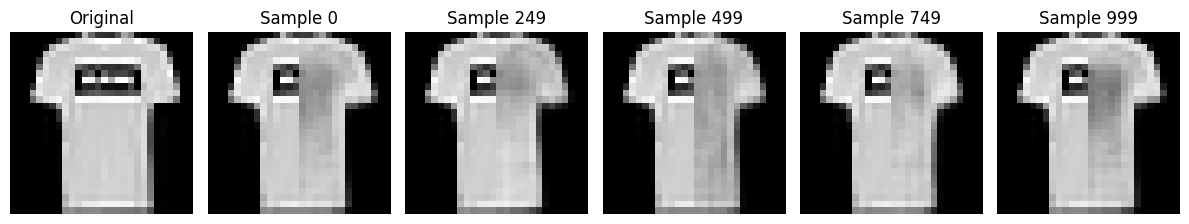

In [75]:
test_img = train_dataset[1][0].unsqueeze(0)
samples, acceptance_rate, posterior_probs = complete_image(vae, test_img=test_img, use_encoder=False, step_size=0.1, num_samples=1000)
print(f"Acceptance rate: {acceptance_rate:.2f}")
visualize_samples(test_img, samples)

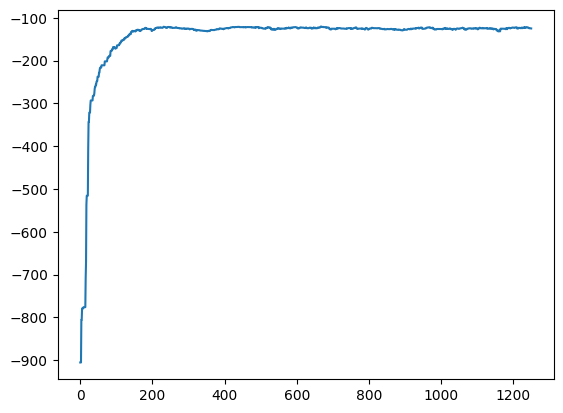

In [76]:
plt.plot(posterior_probs)

In [ ]:
_ = complete_image(vae, test_img=train_dataset[1][0].unsqueeze(0), use_encoder=True, proposal_scale=1.0, num_samples=1000)